# Multimodal DataLoader and Training


#### Dataloader Scripts are Modified from the link:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

## Modules and Other Functions

In [1]:
import os, torch, torchvision, time, copy, timm
from skimage import transform
from __future__ import print_function, division
import torch.nn as nn, torch.optim as optim, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils 
from PIL import Image
from sklearn.metrics import confusion_matrix

device = 'cuda'
detection = 'head'
MM_training = 1

image_root = '/kaggle/input/source-fpus23/Dataset/four_poses'
datalink = {
    'train': '/kaggle/input/ultrasound-fpu23-csv-files/train_labels.csv',
    'valid': '/kaggle/input/ultrasound-fpu23-csv-files/val_labels.csv',
    'test' : '/kaggle/input/ultrasound-fpu23-csv-files/test_labels.csv'
}

def parameters_from_name(sub_dir):
    splitted_foldername = sub_dir.split("_")
    fetus_orientation = splitted_foldername[1]
    
    head_up = 0
    if fetus_orientation[:2] =='hu':
        head_up=1
    front_view = 0
    if fetus_orientation[2:] =='vf':
        front_view=1
        
    if splitted_foldername[2] =='aroundabd':
        location_organ = 0
    if splitted_foldername[2] =='aroundsbd': #There was a wrong folder name 'aroundsbd'
        location_organ = 0

    if splitted_foldername[2] =='longrec':
        location_organ = 1
    if splitted_foldername[2] =='aroundhead':
        location_organ = 2
    if splitted_foldername[2] =='aroundarms':
        location_organ = 3
    if splitted_foldername[2] =='aroundlegs':
        location_organ = 4
        
    location_organ = location_organ/4 #Normalizing
    invasive=1
    if splitted_foldername[3] =='h':
        invasive=0
        
    return np.array([head_up, front_view, location_organ, invasive])

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.yticks([])  
    plt.xticks([])  
    plt.imshow(inp)
    plt.savefig('Augmented_ultrasound.pdf', bbox_inches = 'tight') 
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Multimodal DataLoader

In [2]:
class MultimodalDataset(Dataset):
    # Modified from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, csv_file, root_dir, transform = None, detection = None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.detection = detection

    def __len__(self):
        return len(self.csv_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sub_dirs = self.csv_frame.iloc[idx, 0]
        img_name = self.root_dir + sub_dirs +'/' + self.csv_frame.iloc[idx, 1]
        image = Image.open(img_name)
        labels = self.csv_frame.iloc[idx, 3]
        
        if self.detection:
            detected = 0
            if self.detection in labels:
                detected = 1
            labels = detected

        other_inputs = parameters_from_name(sub_dirs)
        sample = {'image': image, 'information': other_inputs,'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

## Multimodal Transform
Using existing transforms provided by Torchvision.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

class MM_transform(object):
    def __init__(self, phase):
        assert isinstance(phase,(str))
        self.phase = phase
        
    def __call__(self, sample):
        image, information, labels = sample['image'],sample['information'], sample['labels']
        trnsfrm = data_transforms[self.phase]
        image = trnsfrm(image)
        
        return {'image': image, 'information': information, 'labels': labels}

## Dataloader with Multimodal Transform

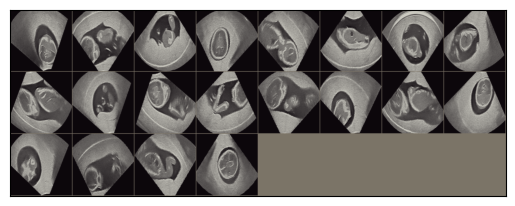

In [4]:
def dataset_phase(phase, detection):
    return MultimodalDataset(csv_file = datalink[phase], root_dir = image_root,
                        transform = MM_transform(phase), detection = detection)

def dataloader_phase(phase):
    return DataLoader(dataset[phase], batch_size = 20,shuffle=True, num_workers=0)
    
dataset = {x: dataset_phase(x, detection) for x in ['train', 'valid', 'test']}
dataloaders = {x: dataloader_phase(x) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
               
sample_batch = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(sample_batch['image'])
imshow(out)#,title= [x for x in sample_batch['labels'] ])

## Pre-trained Models

In [5]:
Num_class = 2

class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
    
#model_ft = models.resnet50(pretrained=False)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, Num_class)
#PATH = '/kaggle/input/unimodal-fine-tuning-before-mm/fine_tuned_model.pt'
#model_ft.load_state_dict(torch.load(PATH, map_location=device))
#model_ft.fc = NullNet()

model_ft = timm.create_model('vit_large_patch16_224', pretrained=False, num_classes=Num_class)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, Num_class)
PATH = '/kaggle/input/unimodal-fine-tuning-before-mm/fine_tuned_model.pt'
model_ft.load_state_dict(torch.load(PATH, map_location=device))
model_ft.head = NullNet()

if MM_training ==0:
    model_fc = nn.Linear(num_ftrs, Num_class) # for unimodal
if MM_training:
    model_fc = nn.Linear(num_ftrs + 4, Num_class).to(torch.float64)

/tmp/ipykernel_19/1433150690.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load(PATH, map_location=device))


## Training Function

In [6]:
def train_model_MM(model, model_fc, criterion, optimizer, scheduler, num_epochs=25, MM_training=1):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batch in dataloaders[phase]:
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['labels'].to(device)
                params = sample_batch['information'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features = model(inputs)
                    if MM_training:
                        features = torch.cat((features, params), 1)
                    outputs = model_fc(features)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_fc.state_dict())
                test_token =1

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_fc.load_state_dict(best_model_wts)
    return model_fc



## MM NN Training

In [7]:
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)
model_fc = model_fc.to(device)
criterion = nn.CrossEntropyLoss()

model_fc = train_model_MM(model_ft, model_fc, criterion, optimizer_fc, exp_lr_scheduler, num_epochs=3, MM_training=MM_training)

Epoch 0/2
----------
train Loss: 0.1202 Acc: 0.9511
valid Loss: 0.0937 Acc: 0.9626
test Loss: 0.0866 Acc: 0.9669

Epoch 1/2
----------
train Loss: 0.0789 Acc: 0.9691
valid Loss: 0.0852 Acc: 0.9662
test Loss: 0.0786 Acc: 0.9692

Epoch 2/2
----------
train Loss: 0.0788 Acc: 0.9688
valid Loss: 0.0904 Acc: 0.9626

Training complete in 39m 25s
Best val Acc: 0.966248


## Confusion Matrix

Test Accuracy: 0.9692154915590864


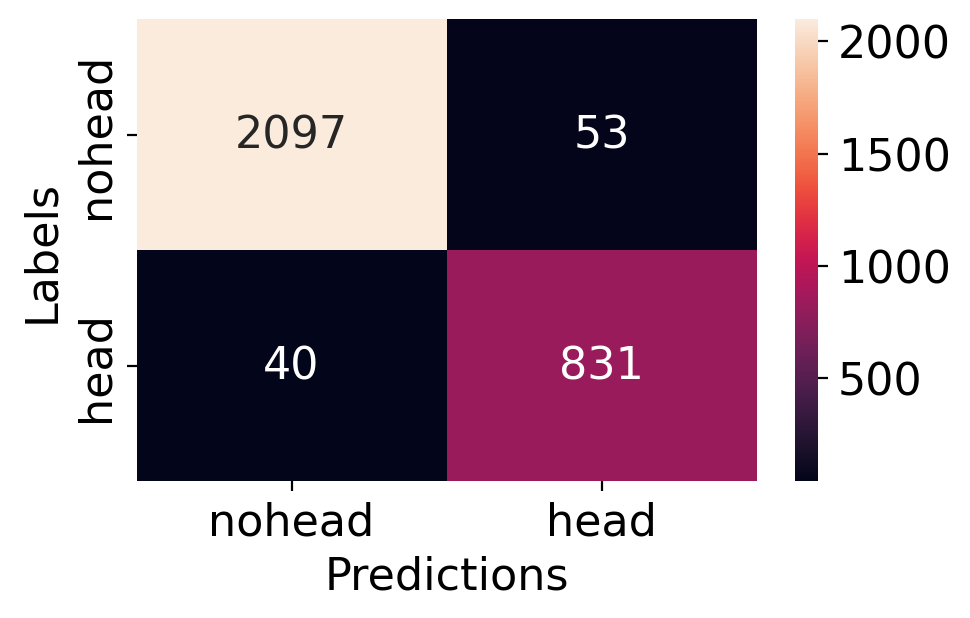

In [8]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for sample_batch in dataloaders['test']:
        inputs = sample_batch['image'].to(device)
        labels = sample_batch['labels'].to(device)
        params = sample_batch['information'].to(device)
        
        features = model_ft(inputs)
        if MM_training:
            features = torch.cat((features, params), 1)
        output = model_fc(features)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

# constant for classes
classes = ('no'+detection, detection)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (5,3),dpi=200)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight') 